# Mosaicing

L'objectif est ici de rassembler plusieurs bouts d'images, ayant un certain recouvrement, afin de faire une seule grande image (comme pour un panorama par exempl).

Ce travail sera fait en plusieurs étapes afin de commencer par traiter un cas simple et améliorer le travail pour atteindre des cas complexes : 

- **Orientation** : On commencera avec des images ayant une même orientation
- **Couleur** : Les images auront les même tons dans un premier temps. Pouvant avoir des teintes différentes,  faudra les rectifier pour obtenir une harmonie de couleurs dans un second temps.
- **Résolution**

In [1]:
# Import
import nbimporter
from utils import mosaicing as utils
import numpy as np
import matplotlib.pyplot as plt
import cv2

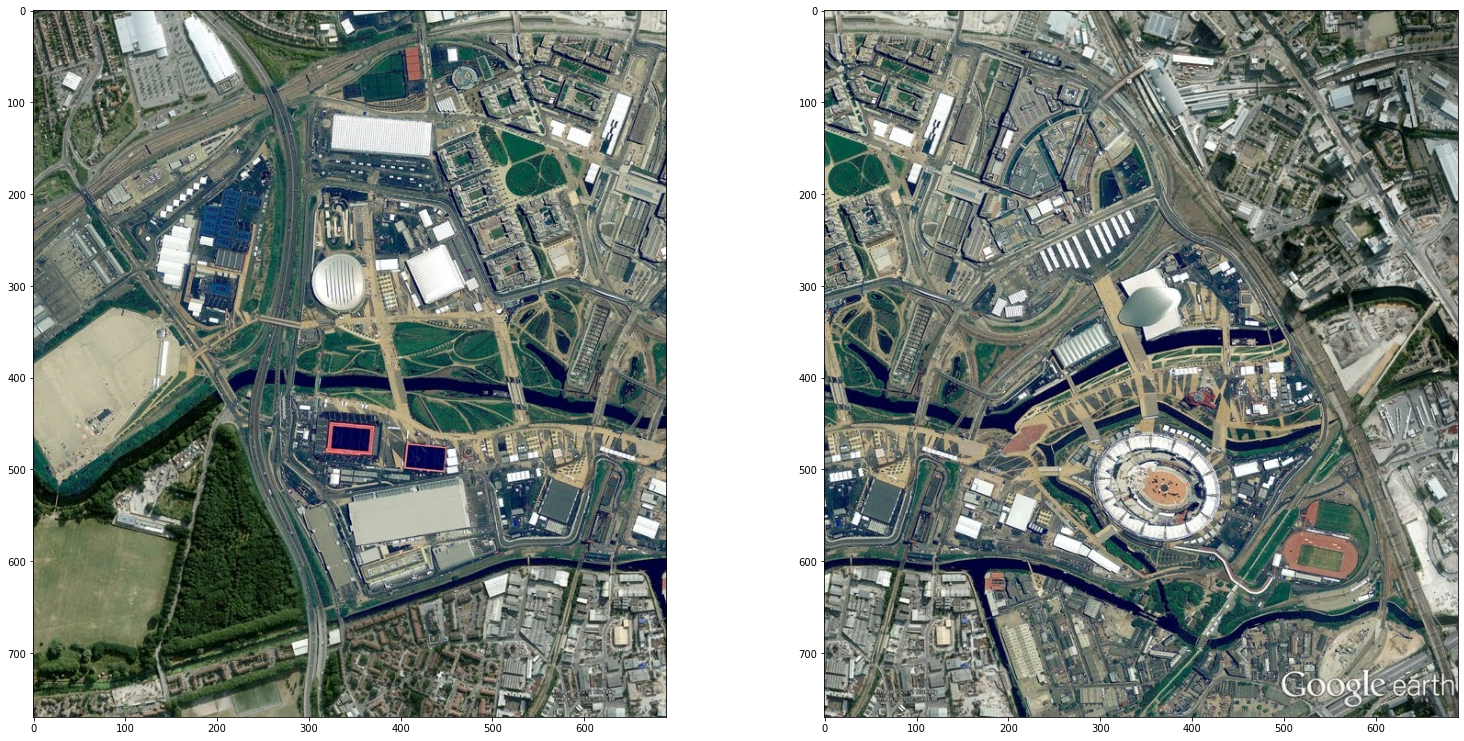

In [2]:
images = utils.load_images("olympic-park", "jpeg", 2)
utils.plot_list(images)

In [3]:
"""
def display_harris(img, harris):
    img[harris > 0.025 * harris.max()]=[0,0,255]
    utils.display_img(img)
    return img


def keypoints_detection_harris(img):
    gray = to_gray(img)
    harris = cv2.cornerHarris(src=gray, blockSize=2, ksize=3, k=0.04)
    harris = cv2.dilate(harris, None)
    print(harris.dtype)
    img = display_harris(img, harris)
    return harris
"""

'\ndef display_harris(img, harris):\n    img[harris > 0.025 * harris.max()]=[0,0,255]\n    utils.display_img(img)\n    return img\n\n\ndef keypoints_detection_harris(img):\n    gray = to_gray(img)\n    harris = cv2.cornerHarris(src=gray, blockSize=2, ksize=3, k=0.04)\n    harris = cv2.dilate(harris, None)\n    print(harris.dtype)\n    img = display_harris(img, harris)\n    return harris\n'

In [4]:
def to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def keypoints_detection(img):
    #utils.display_img(img)
    img = to_gray(img)
    orb = cv2.ORB_create(nfeatures=2000)
    
    kp, des = orb.detectAndCompute(img, None)
    
    # cv2.drawKeypoints(img, kp, None, color=(0,0,255), flags=0)
    #display_orb(im2)
    return kp,des

In [5]:
def display_orb(img):
    plt.imshow(img)
    plt.show()

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def draw_matches(img1, kpts1, img2, kpts2, matches, color=(0,0,255), title=""):
    '''img1 and img2 are color images.'''
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]),
                           img1.shape[1]+img2.shape[1], 
                           3), 
                           dtype=np.uint8)
    img_matches = cv2.drawMatchesKnn(img1, kpts1, img2, kpts2, 
                          matches, 
                          img_matches,
                          matchColor=color,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12,4))
    plt.imshow(bgr2rgb(img_matches))
    plt.title(title + " - %d matches" % (len(matches),))

In [6]:
def match_points(des1, des2):
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)
    #matches = bf.match(des1, des2)
    matches = bf.knnMatch(des1, des2, k=2)
    print(len(matches))
    return matches

In [7]:
def find_good_matches(matches):
    good = []
    for m, n in matches:
        if m.distance <  0.1 * n.distance:
            good.append([m])
    return good

In [8]:
def find_homography(kp1, kp2, matches):
    
    min_matches = 5
    if len(matches) < min_matches:
        print("Not enough matches. Could not strap images")
        return []
    
    tmp = []
    
    for m in matches:
        tmp.append(m[0])

    src_pts = np.float32([kp1[m.queryIdx].pt for m in tmp]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in tmp]).reshape(-1, 1, 2)
    
    #print(src_pts.shape, dst_pts.shape)
    
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    #h, w = im
    print(H)    
    return H


In [9]:
def warp(images, H):
    
    im1 = images[0]
    im2 = images[1]
    
    dst = cv2.warpPerspective(im1, H, ((im1.shape[1] + im2.shape[1]), im2.shape[0]))
    utils.display_img(dst)
    dst[0:im2.shape[0], 0:im2.shape[1]] = im2
    return dst

In [10]:
def mosaicing(images):
    des = []
    kp = []
    for img in images:
        kp_tmp, des_tmp = keypoints_detection(img)
        kp.append(kp_tmp)
        des.append(des_tmp)
    
    matches = match_points(des[0], des[1])
    ## draw_matches(images[0], kp[0], images[1], kp[1], matches[:50], color =(0,0,255), title="All matches")
    good_matches = find_good_matches(matches)
    print(len(good_matches))
    draw_matches(images[0], kp[0], images[1], kp[1], good_matches, color =(0,0,255), title="Good matches")
    #utils.plot_list(kp)
    H = find_homography(kp[0], kp[1], good_matches)
    merged = warp(images, H)
    
    return merged

2000
114
[[ 9.99413973e-01 -4.40698957e-06  5.10006360e+02]
 [-1.53694252e-04  1.00003842e+00  5.09803049e-03]
 [-4.40231263e-07  1.03424097e-07  1.00000000e+00]]


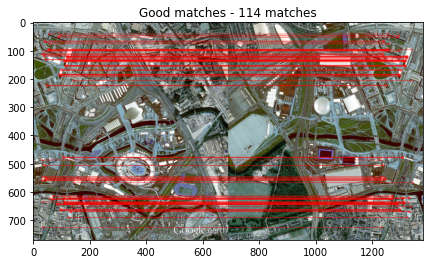

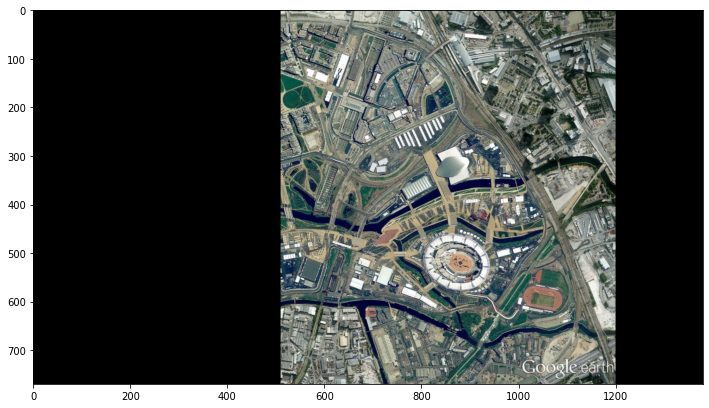

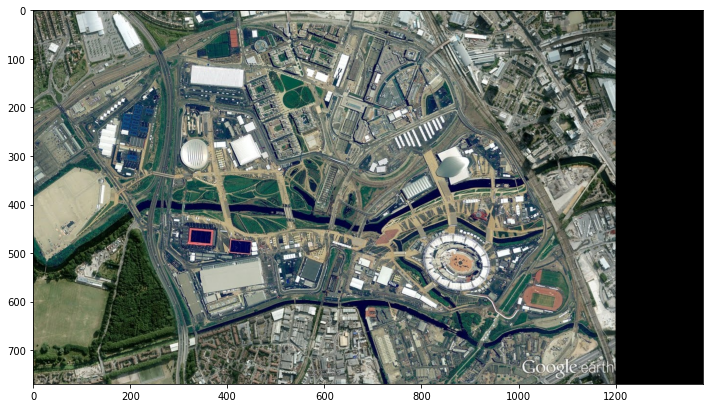

In [11]:
images.reverse()
merged = mosaicing(images)

utils.display_img(merged)
#merged = cv2.cvtColor(merged, cv2.COLOR_RGB2BGR)
#cv2.imwrite("output.jpg",merged)
#plt.figure(figsize = (12, 12))
#plt.imshow(image)

On veut seulement garder les matchs forts, qui ont du sens dans notre situation. Pour faire cela, on utilise **David Lowe's ratio test**. 

Son test de ratio permet d'augmenter la robustesse de l'algorithme **SIFT** (La scale-invariant feature transform (SIFT), que l'on peut traduire par « transformation de caractéristiques visuelles invariante à l'échelle », est un algorithme utilisé dans le domaine de la vision par ordinateur pour détecter et identifier les éléments similaires entre différentes images numériques).

Le but est d'exclure les points trop distincts entre eux. On exclut ces points lorsque la distance de **match** est au dessus d'un certain threshold. Ainsi, nous préservons les meilleurs matches qui doivent correspondre à la partie commune entre nos deux images.

# Réunir les deux images

Maintenant que nous avons extrait le points d'intérêt, que nous les avons reliés et que nous avons gardé seulement les **matches** qui nous intéressent, on veut rélier nos deux images.

https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780